In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from numpy import pi as npi
from scipy.stats import multivariate_normal
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import corner
from scipy.stats import norm

Text(0, 0.5, '$h(t)$')

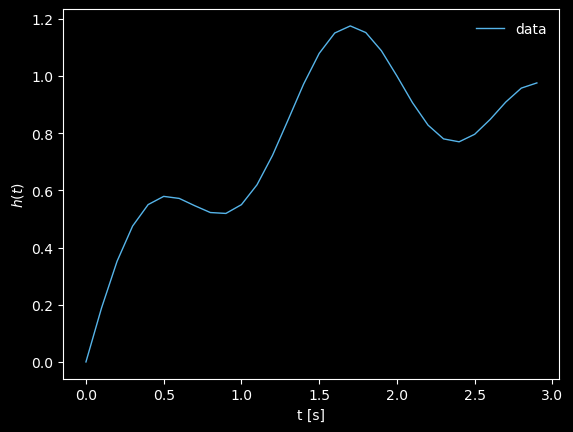

In [11]:
A0_inj, f0_inj = 0.2, 0.75
noise_sigma = 1.0
times = np.arange(0, 3, 0.1)
noise_sigma = 0.1


injection = A0_inj * np.sin(2*npi*f0_inj*times) + times - 0.25*times**2

# lets make data noiseless for convenience 
data = injection #+ noise_sigma*np.random.normal(size=times.size)

## Lets make some plots of out data to check that it looks ok
ax = plt.gca()

# time domain plot
ax.plot(times, data, label='data', color='#56B4E9', lw=1.0)
#ax.plot(times, injection, label='simulated signal', color='#D55E00', lw=1.0)
ax.legend(frameon=False)
ax.set_xlabel('t [s]')
ax.set_ylabel('$h(t)$')

In [12]:
class nested_sample_autoreg():

    def __init__(self, data, times, noise_sigma):
        self.data = data
        self.times = times
        self.delt = times[1] - times[0]
        self.noise_sigma = noise_sigma
        self.npar = 3 # only b, tau and sigma parameters

    def AR1(self, theta):

        min_vals = np.array([-6, 0.001, 0.01])
        max_vals = np.array([6, 20, 10])
        
        theta[0:3] = (max_vals - min_vals) * theta[0:3] + min_vals

    
        return theta
    
    

    def loglike(self, theta,):


        
        b, tau, sigma = theta[0], theta[1], theta[2]
        
        ## these are the values at the nodes
        psi_i = self.data

        
        ## the mean-subtracted values i.e. psi*
        psi_star = psi_i - b*tau
        
        
        ## initializing an array of autoregressive predictions
        psi_hat = np.zeros(psi_i.size)
        
    
        # the first element we leave zero
        psi_hat[1:] = np.exp(-self.delt / tau) * (psi_star[0:-1]) 
        
        var = 0.5*tau*sigma**2 * (1 - np.exp(-2*self.delt / tau))
        
        # probability for the CAR(1) model. 
        log_prob = - 0.5 * (psi_star - psi_hat)**2 / var  - 0.5 * np.log(2 * np.pi * var)
        
        # no loglikelihood term anymore
        # log-likelihood for the data
        #loglike = -0.5 * (self.data - psi_i)**2 / self.noise_sigma**2

        return log_prob.sum()



### Unmodeled fitting. 

We will use a nested sampler called dynesty to sample this high dimensional space. Nested samplers usually produce random samples from a uniform N-dimensional unit hypercube, where N is the number of independent parameters. 

$$\theta_i \sim U[0, 1) \qquad i \in [1, N]$$

We need to provide a nested sampler two functions to work. 

1. A prior transformation function to transform the unit hypercube draws into draws from out actual prior. 

In the example below the function function `AR1` serves as the prior transformation function. It provides a uniform prior for $b, \tau and \sigma$. It also provides a uniform prior for each $\psi_i \sim U[-6, 6]$

2. A likelihood function to calculate $p(d | \theta)$ for our draws. 


Remember that for a $CAR(1)$ process

$$p\left (\psi(t) | \psi(t'), \tau, \sigma, b \right) = \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t) - \hat{\psi} (t) \right)^2}{2 \Omega^2(t)}\right]$$


where $$\hat{\psi}(t) \equiv E \left (\psi(t) | \psi (t') \right) - b \tau  = e^{-\Delta t / \tau} \left (\psi(t') - b \tau \right )$$


and $$\Omega(t) = \frac{\tau \sigma^2}{2} \left(1 - e^{-2 \Delta t / \tau} \right)$$


$$p\left ( \psi(t_1), \psi(t_2), ..., \psi(t_n)  |\tau, \sigma, b \right) = \prod_i^n \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t_i) - \hat{\psi} (t_i) \right)^2}{2 \Omega^2(t_i)}\right]$$

Since this is a forecasting excercise, let's make our lives easier and assume that there is no noise

In [13]:
tcut = 1.5

ar_obj = nested_sample_autoreg(data[times <=tcut], times[times <= tcut], noise_sigma)

engine = NestedSampler(ar_obj.loglike, 
                       ar_obj.AR1, ar_obj.npar,
                       bound='multi', nlive=250)
engine.run_nested(dlogz=0.1,print_progress=True )

796it [00:00, 2180.70it/s, bound: 0 | nc: 22 | ncall: 7045 | eff(%): 11.299 | loglstar:   -inf < -18.118 <    inf | logz: -23.223 +/-  0.126 | dlogz: 30.993 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1058it [00:01, 720.03it/s, bound: 6 | nc: 6 | ncall: 10377 | eff(%): 10.196 | loglstar:   -inf < -10.246 <    inf | logz: -16.085 +/-  0.139 | dlogz: 24.163 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1215it [00:01, 627.98it/s, bound: 9 | nc: 3 | ncall: 11427 | eff(%): 10.633 | loglstar:   -inf < -5.193 <    inf | logz: -11.982 +/-  0.150 | dlogz: 19.858 >  0.100] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1328it [00:01, 592.55it/s, bound: 11 | nc: 1 | ncall: 12126 | eff(%): 10.952 | loglstar:   -inf < -2.398 <    inf | logz: -9.325 +/-  0.153 | dlogz: 16.742 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1418it [00:01, 609.63it/s, bound: 12 | nc: 3 | ncall: 12571 | eff(%): 11.280 | loglstar:   -inf < -0.373 <    inf | logz: -7.599 +/-  0.155 | dlogz: 16.432 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1501it [00:02, 535.88it/s, bound: 14 | nc: 41 | ncall: 13324 | eff(%): 11.265 | loglstar:   -inf <  1.447 <    inf | logz: -6.006 +/-  0.159 | dlogz: 14.506 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1569it [00:02, 404.81it/s, bound: 17 | nc: 13 | ncall: 14442 | eff(%): 10.864 | loglstar:   -inf <  2.702 <    inf | logz: -4.889 +/-  0.161 | dlogz: 13.115 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1725it [00:02, 423.04it/s, bound: 20 | nc: 4 | ncall: 15506 | eff(%): 11.125 | loglstar:   -inf <  5.279 <    inf | logz: -2.782 +/-  0.165 | dlogz: 10.486 >  0.100] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1776it [00:02, 429.41it/s, bound: 21 | nc: 5 | ncall: 15807 | eff(%): 11.236 | loglstar:   -inf <  6.103 <    inf | logz: -2.115 +/-  0.167 | dlogz:  9.615 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1901it [00:03, 430.06it/s, bound: 23 | nc: 7 | ncall: 16683 | eff(%): 11.395 | loglstar:   -inf <  8.143 <    inf | logz: -0.548 +/-  0.172 | dlogz:  7.590 >  0.100] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2056it [00:03, 499.33it/s, bound: 25 | nc: 4 | ncall: 17305 | eff(%): 11.881 | loglstar:   -inf < 10.004 <    inf | logz:  1.005 +/-  0.176 | dlogz:  5.419 >  0.100] 


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

2182it [00:03, 605.67it/s, bound: 26 | nc: 4 | ncall: 17679 | eff(%): 12.342 | loglstar:   -inf < 11.106 <    inf | logz:  1.943 +/-  0.178 | dlogz:  3.990 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2406it [00:03, 698.15it/s, bound: 28 | nc: 9 | ncall: 18429 | eff(%): 13.056 | loglstar:   -inf < 12.629 <    inf | logz:  3.071 +/-  0.182 | dlogz:  2.080 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2501it [00:04, 686.49it/s, bound: 29 | nc: 4 | ncall: 18806 | eff(%): 13.299 | loglstar:   -inf < 13.101 <    inf | logz:  3.396 +/-  0.183 | dlogz:  1.495 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2727it [00:04, 805.86it/s, bound: 31 | nc: 13 | ncall: 19558 | eff(%): 13.943 | loglstar:   -inf < 13.754 <    inf | logz:  3.885 +/-  0.185 | dlogz:  0.652 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2986it [00:04, 963.70it/s, bound: 33 | nc: 3 | ncall: 20305 | eff(%): 14.706 | loglstar:   -inf < 14.181 <    inf | logz:  4.139 +/-  0.186 | dlogz:  0.226 >  0.100] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3186it [00:04, 682.22it/s, +250 | bound: 34 | nc: 1 | ncall: 21194 | eff(%): 16.406 | loglstar:   -inf < 14.690 <    inf | logz:  4.308 +/-  0.189 | dlogz:  0.000 >  0.100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


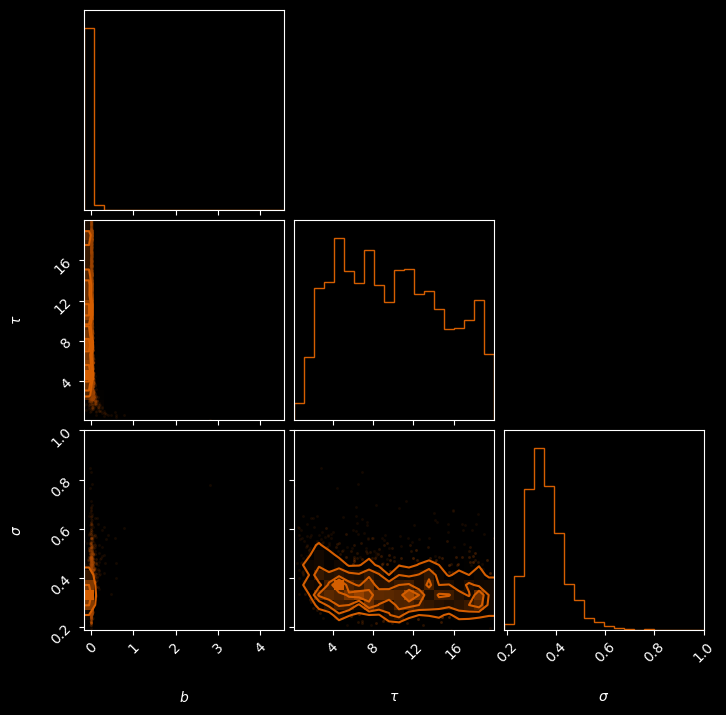

In [14]:
res = engine.results
weights = np.exp(res['logwt'] - res['logz'][-1])
weights[-1] = 1 - np.sum(weights[0:-1])

post_samples = resample_equal(res.samples, weights)
fig = corner.corner(
    post_samples[:, 0:3], 
    labels=['$b$', '$\\tau$', '$\\sigma$'], color='#D55E00')

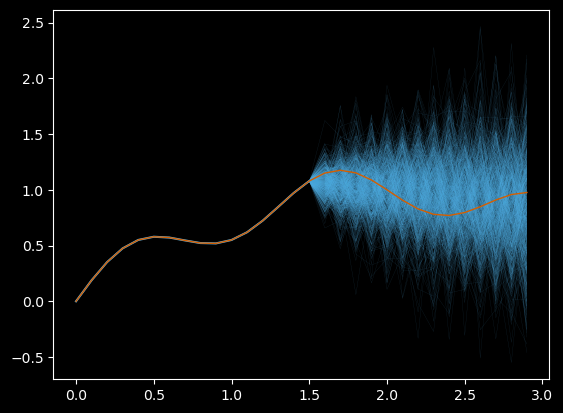

In [15]:
plt.plot(times[times <= tcut], data[times <=tcut], color='#56B4E9')


for ii in range(1000):
    
    b, tau, sigma = post_samples[ii, 0], post_samples[ii, 1], post_samples[ii, 2]
    
    delt = times[times >= tcut] - tcut
    
    expectation = np.exp( - delt/tau) * (data[times <=tcut][-1] - b*tau) + b * tau
    
    variance = 0.5*tau * sigma**2 * (1 - np.exp( - 2*delt/tau))
    
    forecast = np.random.default_rng().normal(expectation, np.sqrt(variance))
    
    plt.plot(times[times >=tcut], forecast, color='#56B4E9', alpha=0.2, lw=0.2)

plt.plot(times, data, label='data', color='#D55E00', lw=1.0)

In [16]:
post_samples.shape

(3436, 3)